In [1]:
import xara
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ExoRIM as exo
import tensorflow as tf
from celluloid import Camera
from IPython.display import HTML
%matplotlib inline

In [ ]:
# Defines physical variables
ISZ = 32  # number of pixels for the image
cwavel = 0.5e-6 # Wavelength [m]
pscale = 0.001 # plate scale [mas/pixel]
m2pix = xara.core.mas2rad(pscale) * ISZ / cwavel  # [1/m] units for (u, v) Fourier space

In [3]:
# circle_mask = np.zeros((21, 2))
# for i in range(21):
#     circle_mask[i,0] = (100 + 10*np.random.normal())*np.cos(2*np.pi*i/21)
#     circle_mask[i,1] = (100 + 10*np.random.normal())*np.sin(2*np.pi*i/21)
mask = np.array([[5, 0], [-5, 0]])
kpi = xara.KPI(array=mask)

Attempting to build KPI from array None
1 distinct baselines were identified
10 first singular values for this array:
[1.]

        Summary of properties for no_name
        ---------------------------------------------------------------
        -   2 sub-apertures
        -   1 distinct baselines
        -   0 Ker-phases ( 0.0 % target phase information recovery)
        -   1 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully created


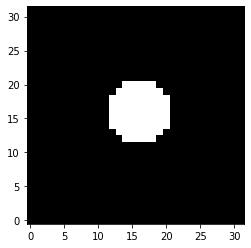

In [4]:
image_coords = np.arange(N) - N / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image1 = np.zeros_like(xx)
rho_squared = (xx) ** 2 + (yy) ** 2
image1 += rho_squared**(1/2) < 5
# image1 += (xx - 30) ** 2 + (yy - 30) ** 2 < 10
plt.imshow(image1, cmap="gray")

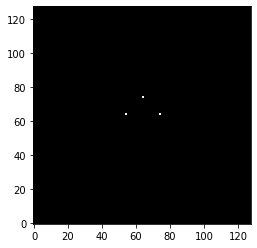

In [5]:
# Visualization of 3 sub aperture intereference
image_coords = np.arange(128) - 128 / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
rho = np.sqrt((xx-5) ** 2 + (yy) ** 2)
image += np.sqrt((xx-10) ** 2 + (yy) ** 2) < 1
image += np.sqrt((xx+10) ** 2 + (yy) ** 2) < 1
image += np.sqrt((xx) ** 2 + (yy-10) ** 2) < 1
plt.imshow(image, cmap="gray")

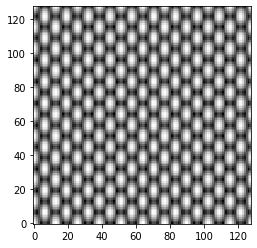

In [6]:
image_hat = np.fft.fft2(image)
plt.imshow(np.abs(image_hat), cmap="gray")

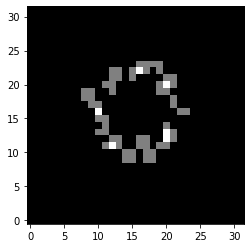

In [7]:
N = 21
L = 6
pixels = 32
var = 1
x = (L + np.random.normal(0, var, N)) * np.cos(2 * np.pi * np.arange(N) / N)
y = (L + np.random.normal(0, var, N)) * np.sin(2 * np.pi * np.arange(N) / N)
circle_mask = np.array([x, y]).T
image_coords = np.arange(pixels) - pixels / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
for x in circle_mask:
    rho_squared = np.sqrt((xx-x[0]) ** 2 + (yy - x[1]) ** 2)
    image += np.sqrt(rho_squared) < 1
plt.imshow(image, cmap="gray")

210 distinct baselines found. Mask has 0 redundant baselines
5.24
5.242563825447032


0.0022558547131876364

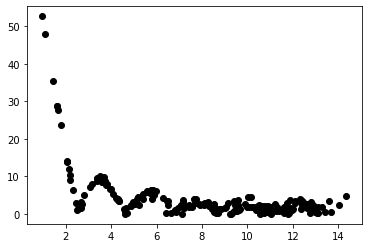

In [8]:
B = exo.operators.Baselines(circle_mask)
wavel = 0.5e-6
pixels=32
plate_scale = 5.24#2.2 * 1000 / 2048 * 3 # James Webb plate scale, #exo.definitions.rad2mas(1.22 * wavel / 4 / L)/10 # mas / pixel at the diffraction limit
print(plate_scale)
print(exo.definitions.rad2mas(1.22 * wavel / 4 / L))
ndftm = exo.operators.NDFTM(B.UVC, wavel, pixels, plate_scale)
V = ndftm.dot(image1.flatten())
bas = np.sqrt(B.UVC[:, 0]**2 + B.UVC[:, 1]**2)
plt.plot(bas, np.abs(V), "ko")
np.abs(V).min()

In [ ]:
image_hat = np.fft.fft2(image)
plt.imshow(np.abs(image_hat), cmap="gray")

In [10]:
def chisq_real_image(image, A, vis, sigma_r, sigma_i=None):
    if sigma_i is None:
        sigma_i = sigma_r
    sig_i = tf.cast(sigma_i, tf.float32)
    sig_r = tf.cast(sigma_r, tf.float32)
    im = exo.definitions.cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
#     chisq = 0
    chisq_r = 0.5 * tf.reduce_mean(((tf.math.real(samples) - tf.cast(tf.math.real(vis), exo.definitions.dtype)) / sig_r)**2, axis=1)
    chisq_i = 0.5 * tf.reduce_mean(((tf.math.imag(samples) - tf.cast(tf.math.imag(vis), exo.definitions.dtype)) / sig_i)**2, axis=1)
    return (chisq_r, chisq_i)

def gradchisq_real_imag(image, A, vis, sigma_r, sigma_i=None):
    if sigma_i is None:
        sigma_i = sigma_r
    sig_i = tf.cast(sigma_i, tf.float64)
    sig_r = tf.cast(sigma_r, tf.float64)
    ima = tf.constant(image, tf.float64)
    with tf.GradientTape() as tape:
        tape.watch(ima)
#         im = exo.definitions.cast_to_complex_flatten(ima)
        samples = tf.einsum("ij, ...j -> ...i", tf.math.real(A), ima)
        chisq_r = 0.5 * tf.reduce_mean(((samples - tf.cast(tf.math.real(vis), tf.float64)) / sig_r)**2, axis=1)
    grad_real = tape.gradient(chisq_r, ima)
    with tf.GradientTape() as tape:
        tape.watch(ima)
#         im = exo.definitions.cast_to_complex_flatten(ima)
        samples = tf.einsum("ij, ...j -> ...i", tf.math.imag(A), tf.cast(ima, tf.float64 ))
        chisq_i = 0.5 * tf.reduce_mean(((samples - tf.cast(tf.math.imag(vis), tf.float64)) / sig_i)**2, axis=1)
    grad_imag = tape.gradient(chisq_i, ima)
    return grad_real, grad_imag
    
def gradchisq_vis(image, A, vis, sigma):
    ima = tf.constant(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(ima)
        chisq = exo.definitions.chisq_vis(ima, A, vis, sigma)
    return tape.gradient(chisq, ima)

from matplotlib.lines import Line2D
def movie(gtruth, images, x, chisq, title, filename, xlabel):
    fig, (gt, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10), dpi=80)
    fig.suptitle(title)
    cam = Camera(fig)
    fig.tight_layout(pad=5.0)
    ax2.set_ylabel("Log likelihood")
    ax2.set_xlabel(xlabel)
    d = int(np.sqrt(images.shape[1]))
#     handles = []
#     for key, item in chisq.items():
#         handles.append(Line2D([0], [0], color=item[1], label=key))
#     ax2.legend(handles, loc="upper right")
    for i in range(images.shape[0]):
        im = images[i].reshape((d, d))
        gt.imshow(gtruth, cmap="gray")
        ax1.imshow(im, cmap="gray")
        for key, item in chisq.items():
            loss = item[0]
            color = item[1]
            ax2.plot(x[:i+1], loss[:i+1], c=color, lw=2)
        cam.snap()
    animation = cam.animate()
    animation.save(f"{filename}.mp4", writer="ffmpeg")
    return HTML(animation.to_html5_video())

def movie_with_grad(gtruth, images, grad_r, grad_i, grad_vis_1, grad_vis_2, x, chisq, mse, title, filename, xlabel):
    fig, axes = plt.subplots(3, 3, figsize=(30, 15), dpi=80)
    fig.suptitle(title)
    cam = Camera(fig)
    fig.tight_layout(pad=5.0)
    axes[0, 2].set_ylabel("Log likelihood")
    axes[0, 2].set_xlabel(xlabel)
    d = int(np.sqrt(images.shape[1]))
    axes[0, 0].set_title("Ground truth")
    axes[0, 1].set_title("Test image")
    axes[1, 0].set_title(r"Gradient of $\chi^2_{real}$")
    axes[1, 1].set_title(r"Gradient of $\chi^2_{imag}$")
    axes[1, 2].set_title(r"Gradient of $\chi^2_{vis}$ with AutoGrad")
    axes[2, 0].set_title(r"Gradient of $\chi^2_{vis}$ analytic")
    axes[2, 1].set_title("Mean squared error $(Y_{pred} - Y)^2$")
    axes[2, 2].remove()
    handles = []
    for key, item in chisq.items():
            handles.append(Line2D([0], [0], color=item[1], label=key))
    axes[0, 2].legend(handles=handles, loc="upper right")
    for i in range(images.shape[0]):
        im = images[i].reshape((d, d))
        axes[0, 0].imshow(gtruth, cmap="gray")
        axes[0, 1].imshow(im, cmap="gray")
        for key, item in chisq.items():
            loss = item[0]
            color = item[1]
            axes[0, 2].plot(x[:i+1], loss[:i+1], c=color, lw=2)

        axes[1, 0].imshow(grad_r[i].reshape((d, d)))
        axes[1, 1].imshow(grad_i[i].reshape((d, d)))
        axes[1, 2].imshow(grad_vis_2[i].reshape((d, d)))
        axes[2, 0].imshow(grad_vis_1[i].reshape((d, d)))
        axes[2, 1].plot(x[:i+1], mse[:i+1], "b")
        cam.snap()
    animation = cam.animate()
    animation.save(f"{filename}.mp4", writer="ffmpeg")
    return HTML(animation.to_html5_video())
    

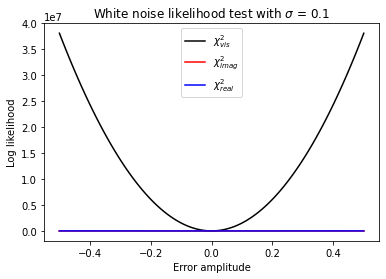

In [11]:
im_copies = image1.flatten().reshape((1, image1.shape[0]**2)) 
im_copies = np.tile(im_copies, [100, 1])
V_copies = V.reshape((1, V.shape[0]))
V_copies = np.tile(V_copies, [100, 1])
sigma = 0.1
log_likelihood = exo.definitions.chisq_vis(im_copies + np.linspace(-50, 50, 100).reshape((100, 1)), ndftm, V_copies, sigma).numpy()
llr, lli = chisq_real_image(im_copies + (np.linspace(-50, 50, 100) / 100).reshape((100, 1)), ndftm, V_copies, sigma)
mse = np.mean(( (np.linspace(-50, 50, 100) / 100).reshape((100, 1)) - im_copies)**2, axis=1)
plt.plot(np.linspace(-50, 50, 100) / 100, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(np.linspace(-50, 50, 100) / 100, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(np.linspace(-50, 50, 100) / 100, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(np.linspace(-50, 50, 100) / 100, mse, color="b", label=r"$\chi^2_{real}$")
plt.xlabel("Error amplitude")
plt.ylabel("Log likelihood")
plt.title(rf"White noise likelihood test with $\sigma$ = {sigma}")
plt.legend()
plt.savefig("chisq_vs_error_amp.png")

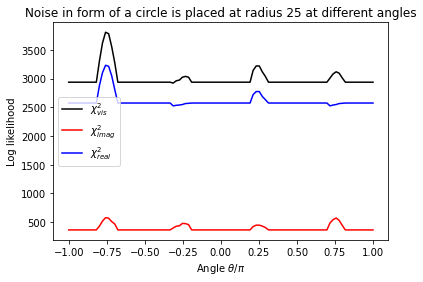

In [24]:
# Add a random circle in the image - first by angle, then by radius, then x then y
angle = np.linspace(-np.pi, np.pi, 100)
r = 25
x_prime = r * np.cos(angle)
y_prime = r * np.sin(angle)
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
for i in range(100):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 5
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
plt.plot(angle / np.pi, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(angle / np.pi, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(angle / np.pi, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.xlabel(r"Angle $\theta/ \pi$")
plt.ylabel("Log likelihood")
plt.title(f"Noise in form of a circle is placed at radius {r} at different angles")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_at_different_angles.png")

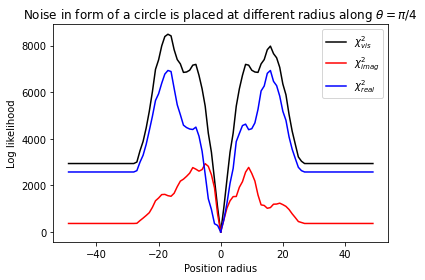

In [25]:
angle = np.array([5 * np.pi/4 for i in range(50)] + [np.pi/4 for i in range(50)])
r = np.array(list(range(50))[::-1] + list(range(50)))
x_prime = r * np.cos(angle)
y_prime = r * np.sin(angle)
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
for i in range(100):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 5
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
plt.plot(r[50:], log_likelihood[50:], color="k", label=r"$\chi^2_{vis}$")
plt.plot(-r[:50], log_likelihood[:50], color="k")
plt.plot(r[50:], lli.numpy()[50:], color="r")
plt.plot(-r[:50], lli.numpy()[:50], color="r", label=r"$\chi^2_{imag}$")
plt.plot(r[50:], llr.numpy()[50:], color="b")
plt.plot(-r[:50], llr.numpy()[:50], color="b", label=r"$\chi^2_{real}$")
plt.xlabel(f"Position radius")
plt.ylabel("Log likelihood")
plt.title(rf"Noise in form of a circle is placed at different radius along $\theta=\pi/4$")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_different_radius.png", bbox_inches="tight")

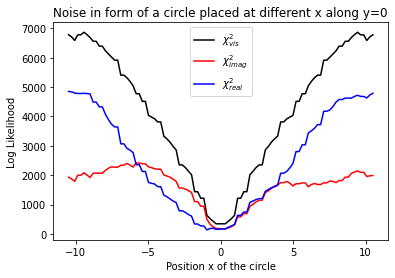

In [26]:
x_prime = np.linspace(-N/2, N/2, 100)
y_prime = [0 for i in range(100)]
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
for i in range(100):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 5
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(x_prime, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(x_prime, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(x_prime, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(x_prime, mse)
plt.xlabel(f"Position x of the circle")
plt.ylabel("Log Likelihood")
plt.title(rf"Noise in form of a circle placed at different x along y=0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_at_different_x.png")

In [27]:
grad_r, grad_i = gradchisq_real_imag(noise, ndftm, V, sigma)
grad_vis_1 = exo.definitions.chisqgrad_vis(noise, tf.cast(ndftm, tf.complex64), V, sigma, pixels, floor=1e-6)
grad_vis_2 = gradchisq_vis(noise, tf.cast(ndftm, tf.complex64), V, sigma)

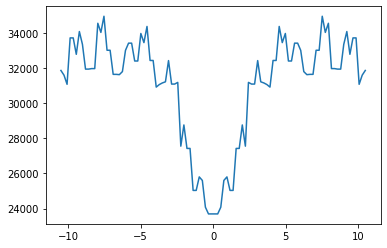

In [33]:
plt.plot(x_prime, grad_vis_1.numpy().max(axis=(1,2,3)))

In [28]:
%%capture
anim = movie(image1, noise, x_prime, 
      {r"$\chi^2_{vis}$" : [log_likelihood, "k"],
        r"$\chi^2_{imag}$": [lli.numpy(), "r"],
        r"$\chi^2_{real}$": [llr.numpy(), "b"]}, 
      rf"White noise likelihood test with $\sigma$ = {sigma}", 
      "chisq_vs_circle_at_different_x_smaller_size",
             "Position x of the circle"
    )

In [29]:
anim

In [30]:
%%capture
anim2 = movie_with_grad(image1, noise,  grad_r.numpy(), grad_i.numpy(), grad_vis_1.numpy(), grad_vis_2.numpy(), x_prime, 
      {r"$\chi^2_{vis}$" : [log_likelihood, "k"],
        r"$\chi^2_{imag}$": [lli.numpy(), "r"],
        r"$\chi^2_{real}$": [llr.numpy(), "b"]},
        mse,
      rf"White noise likelihood test with $\sigma$ = {sigma}", 
      "chisq_vs_circle_at_different_x_smaller_size_with_grad",
             "Position x of the circle"
    )

In [31]:
anim2

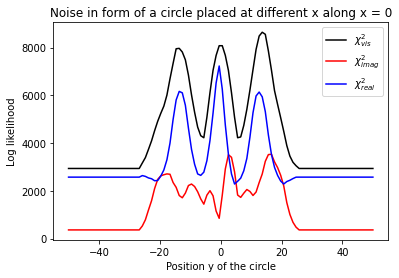

In [21]:
y_prime = np.linspace(-50, 50, 100)
x_prime = [0 for i in range(100)]
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
for i in range(100):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2)
    noise[i] += rho < 10 * sigma * 10
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
plt.plot(y_prime, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(y_prime, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(y_prime, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.xlabel(f"Position y of the circle")
plt.ylabel("Log likelihood")
plt.title(rf"Noise in form of a circle placed at different x along x = 0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_at_different")

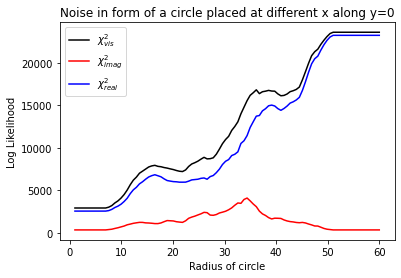

In [22]:
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
rho = np.sqrt((xx - 20) ** 2 + (yy - 20) ** 2)
r = np.linspace(1, 60, 100)
for i in range(100):
    noise[i] += rho < r[i]
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(r, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(r, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(r, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(r, mse)
plt.xlabel(f"Radius of circle")
plt.ylabel("Log Likelihood")
plt.title(rf"Noise in form of a circle placed at different x along y=0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("chisq_vs_circle_of different_sizepng")

In [23]:
noise = np.zeros_like(im_copies.reshape(100, pixels, pixels))
sigma = 0.1
sig = np.linspace(.01, 1, 100)
for i in range(100):
    noise[i] += np.random.normal(1, sig[i], size=(N, N))
noise = noise.reshape(100, pixels**2)
log_likelihood = exo.definitions.chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(sig, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(sig, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(sig, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
# plt.plot(sig, mse)
plt.xlabel(fr"$\sigma$")
plt.ylabel("Log Likelihood")
plt.title(rf"Noise in form of a circle placed at different x along y=0")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
plt.savefig("white_noise_of_different_sigma.png")

ValueError: operands could not be broadcast together with shapes (32,32) (21,21) (32,32) 

In [ ]:
grad_r, grad_i = gradchisq_real_imag(noise, ndftm, V, sigma)
grad_vis_1 = exo.definitions.chisqgrad_vis(noise, tf.cast(ndftm, tf.complex64), V, sigma, pixels, floor=1e-6)
grad_vis_2 = gradchisq_vis(noise, tf.cast(ndftm, tf.complex64), V, sigma)

In [ ]:
%%capture
anim3 = movie_with_grad(image1, noise,  grad_r.numpy(), grad_i.numpy(), grad_vis_1.numpy(), grad_vis_2.numpy(), sig, 
      {r"$\chi^2_{vis}$" : [log_likelihood, "k"],
        r"$\chi^2_{imag}$": [lli.numpy(), "r"],
        r"$\chi^2_{real}$": [llr.numpy(), "b"]},
        mse,
      rf"White noise likelihood test", 
      "chisq_against_white_noise_of_different_sigma",
                        "sigma"
    )

In [ ]:
anim3